In [5]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, DiscriminationThreshold, PrecisionRecallCurve, ROCAUC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, f1_score
from yellowbrick.features import ParallelCoordinates, PCA, RadViz
from yellowbrick.style import set_palette

set_palette('dark')

data_path = Path("../../data").resolve()
os.makedirs(data_path, exist_ok=True)

## Preprocessing

In [6]:
tracks_df = pd.read_parquet(data_path / "tracks.pq")

audio_features = [
    "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "time_signature",
]

artist_features = [
    "artist_chart_tracks",
    "artist_nominations",
    "artist_wins",
    "artist_releases",
    "artist_chart_months",
    "artist_chart_months_recently",
    "artist_releases_recently",
    "major_label",
]


def chart_status(track):
    if track["track_chart_peak"] == 1:
        return "peaked"
    elif track["track_chart_months"] > 3:
        return "charted_3months"
    elif track["track_chart_months"] >= 1:
        return "charted"
    else:
        return "uncharted"


tracks_df["chart_status"] = tracks_df.apply(chart_status, axis=1)
tracks_df["chart_months"] = tracks_df["track_chart_months"].apply(lambda months: months if months <= 5 else 5)
tracks_df["has_female_artist"] = tracks_df["artist_gender"].apply(lambda gender: int("female" in gender))


def create_test_train_datasets(
        df, x_vars, months=1, test_size=0.40, random_state=42,
        y_label="track_chart_months"):
    df = df[x_vars + [y_label]]
    if "major_label" in df.columns:
        df = df.drop(columns="major_label")
    if "chart_status" in df.columns:
        df = df.drop(columns="chart_status")
    if "chart_months" in df.columns:
        df = df.drop(columns="chart_months")
    df = df.dropna()
    X = df.drop(columns=["track_chart_months"])
    y = (df["track_chart_months"] >= months).astype(int)
    return train_test_split(X, y, stratify=y, test_size=test_size,
                            random_state=random_state)


X_audio_train, X_audio_test, y_audio_train, y_audio_test = create_test_train_datasets(tracks_df, audio_features, months=1)
X_artist_train, X_artist_test, y_artist_train, y_artist_test = create_test_train_datasets(tracks_df, artist_features, months=1)

In [16]:
tracks_df[
    (tracks_df["artist_chart_months"] == 0)
    & (tracks_df["track_chart_months"] >= 1)
]

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,duration_ms,...,artist_chart_months_recently,artist_releases_recently,genre,label_name,major_label,label_matched,chart_status,award_status,chart_months,has_female_artist
30,08bNPGLD8AhKpnnERrAc6G,FRIENDS,FRIENDS,1BmxOYHjQv1dKZRr13YRZM,"Marshmello, Anne-Marie","[""64KEffDW9EtZ1y2vBYgq8T"", ""1zNqDE7qDGCsyzJwoh...",1,1,True,202620,...,0.0,17.0,brostep,None,NaN,NaN,charted_3months,0,5.0,0
73,2Yl4OmDby9iitgNWZPwxkd,Be Careful,Invasion of Privacy,4KdtEKjY3Gi0mKiSdy96ML,Cardi B,"[""4kYSro6naA4h99UJvo89HB""]",5,1,True,210787,...,0.0,11.0,rap,None,NaN,NaN,charted,0,3.0,1
79,0EGuSSpuu9wmHCtvb4PdLO,"Sit Still, Look Pretty","Sit Still, Look Pretty",0T8SCja56F4lhZXyOcBTIV,Daya,"[""6Dd3NScHWwnW6obMFbl1BH""]",8,1,False,202221,...,0.0,1.0,alt z,None,NaN,NaN,charted,0,1.0,1
87,1jlG3KJ3gdYmhfuySFfpO1,I'm with You,Let Go,3zXjR3y2dUWklKmmp6lEhy,Avril Lavigne,"[""0p4nmQO2msCgU4IF37Wi3j""]",4,1,False,223066,...,0.0,0.0,canadian pop,None,NaN,NaN,charted_3months,1,5.0,1
103,22PMfvdz35fFKYnJyMn077,Marry You,Doo-Wops & Hooligans,1uyf3l2d4XYwiEqAb7t7fX,Bruno Mars,"[""0du5cEVh5yTK9QJze8zA0C""]",6,1,False,230192,...,0.0,0.0,dance pop,None,NaN,NaN,charted,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14923,6pbCkvCENw0suVGr4Ckkae,Like Glue,Dutty Rock,3nAwSh2fcp3M8voQKZS2as,Sean Paul,"[""3Isy6kedDrgPYoTS1dazA9""]",4,1,False,232506,...,0.0,1.0,dancehall,None,NaN,NaN,charted_3months,0,4.0,0
14928,3TcoHf7nvC8RaDVdfIFjFR,I Could Not Ask for More,Born To Fly,15s0UqAh203Hztsmta1CSn,Sara Evans,"[""7qvsLYsYP0MHD7jkdv6DAG""]",3,1,False,287733,...,0.0,2.0,country dawn,None,NaN,NaN,charted,0,1.0,1
14938,1TZEQi5FfRDef6CcjxNIYB,Wrong Impression,White Lilies Island,2kBKTHX9GHuTUvHe6uRr8z,Natalie Imbruglia,"[""0dlOr0VIysztGWvU1dpjmP""]",5,1,False,256000,...,0.0,1.0,lilith,None,NaN,NaN,charted,0,1.0,1
14952,5pMIsEpL9lx3tACSkxYh1A,Girlfight - radio edit feat. Big Boi & Lil Jon,Girlfight,63F9irZCWYlmbRnwMGR0Kg,"Brooke Valentine, Lil Jon, Big Boi","[""0yqDXjskTQI1nj9bH6W9Ze"", ""7sfl4Xt5KmfyDs2T3S...",1,1,False,216800,...,0.0,0.0,crunk,None,NaN,NaN,charted,0,3.0,1


## Target variable analysis

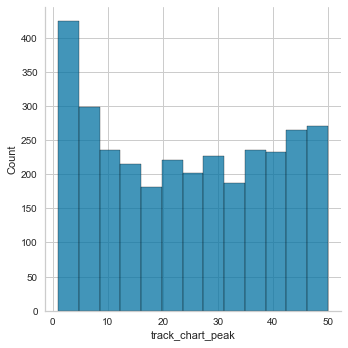

In [3]:
sns.displot(tracks_df["track_chart_peak"])

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='track_chart_months', ylabel='Density'>

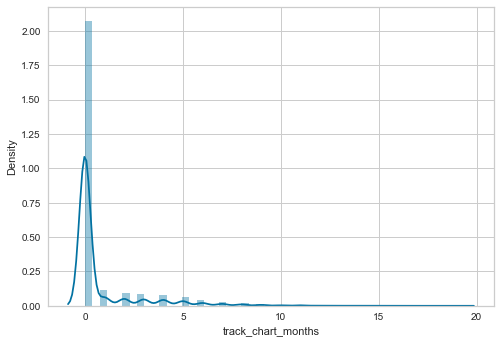

In [4]:
sns.distplot((tracks_df["track_chart_months"]))

In [5]:
print(len(tracks_df[tracks_df["track_chart_months"] > 5]))
print(len(tracks_df[tracks_df["track_chart_months"] > 4]))
print(len(tracks_df[tracks_df["track_chart_months"] > 3]))
print(len(tracks_df[tracks_df["track_chart_months"] > 2]))
print(len(tracks_df[tracks_df["track_chart_months"] > 1]))
print(len(tracks_df[tracks_df["track_chart_months"] == 1]))

671
1035
1498
2000
2545
650


## Audio feature analysis

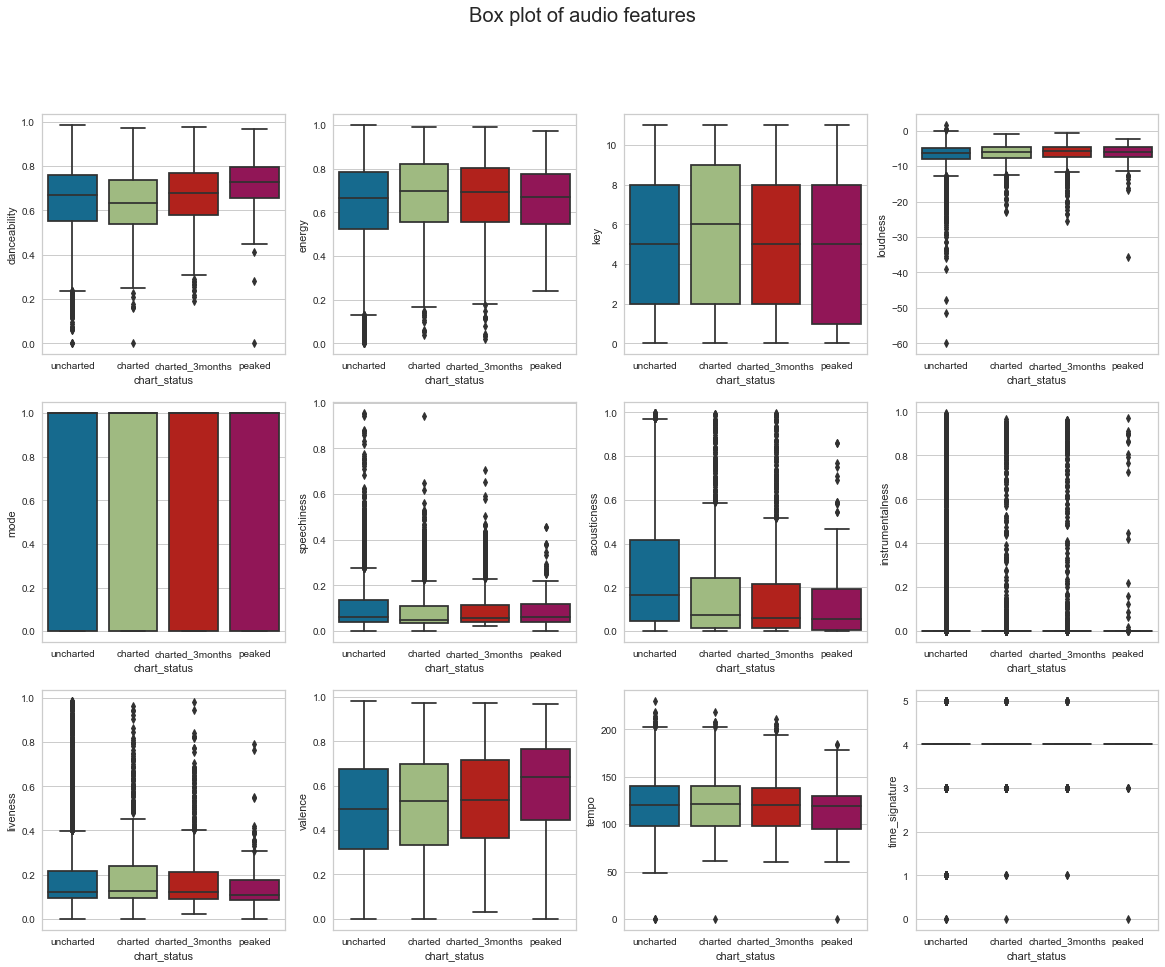

In [6]:
ncols = 4
nrows = int(len(audio_features) / 4)

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 5 * nrows))
fig.suptitle("Box plot of audio features", fontsize=20)

for row in range(nrows):
    for col in range(ncols):
        idx = (row * ncols) + (col + 1) - 1
        if idx > len(audio_features):
            break
        sns.boxplot(data=tracks_df, x="chart_status", y=audio_features[idx], ax=axs[row, col],
                    order=["uncharted", "charted", "charted_3months", "peaked"])

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

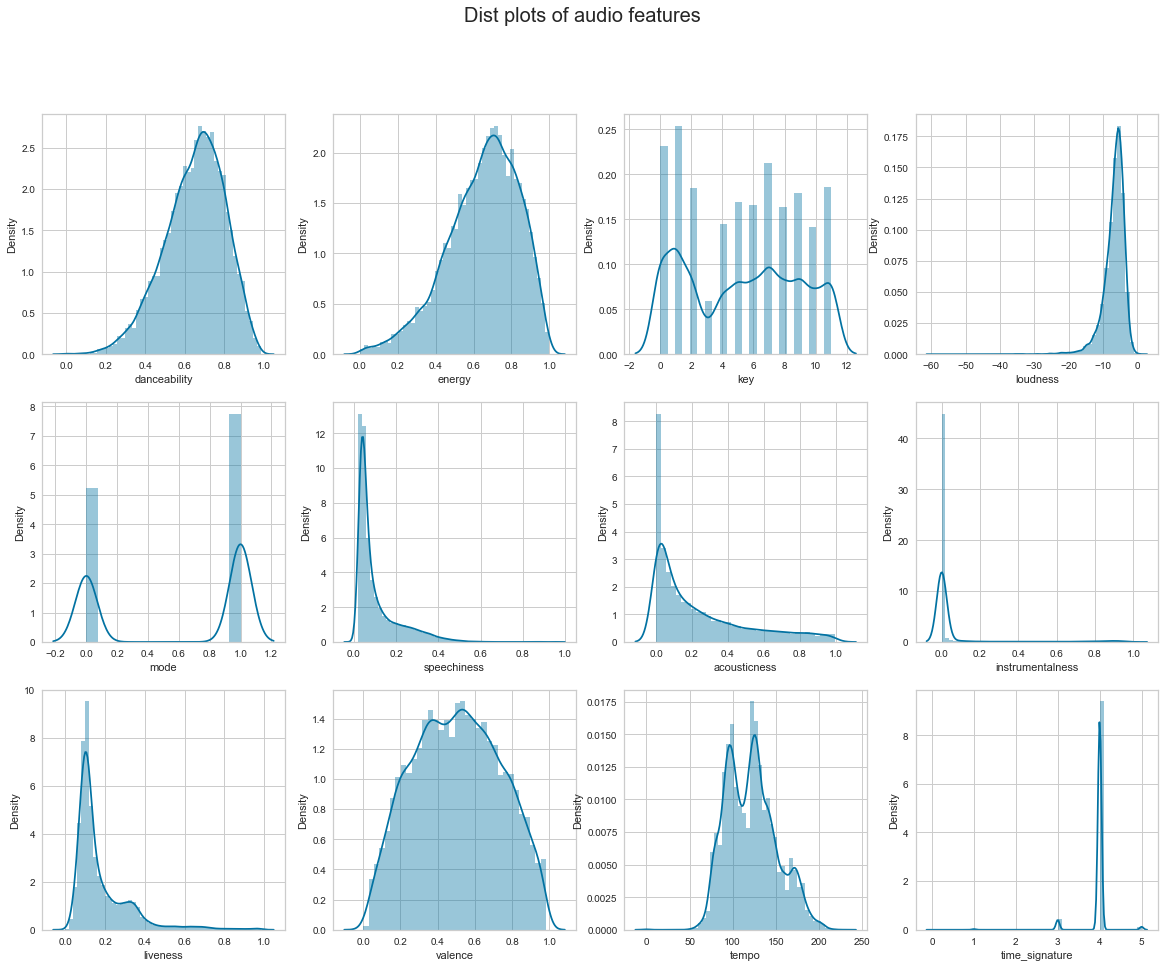

In [7]:
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 5 * nrows))
fig.suptitle("Dist plots of audio features", fontsize=20)

ncols = 4
nrows = int(len(audio_features) / 4)

for row in range(nrows):
    for col in range(ncols):
        idx = (row * ncols) + (col + 1) - 1
        if idx > len(audio_features):
            break
        sns.distplot(tracks_df[audio_features[idx]], ax=axs[row, col]),
                    #order=["uncharted", "charted", "charted_3months", "peaked"])

<AxesSubplot:xlabel='tempo', ylabel='Density'>

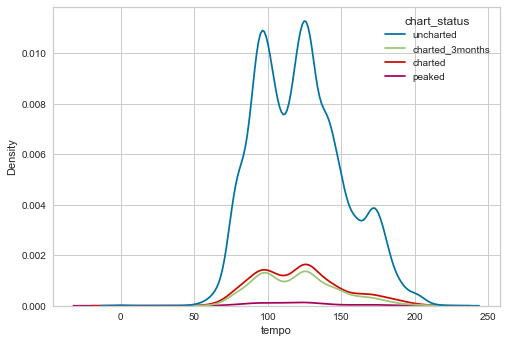

In [8]:
sns.kdeplot(data=tracks_df, x="tempo", hue="chart_status")

## Artist feature analysis

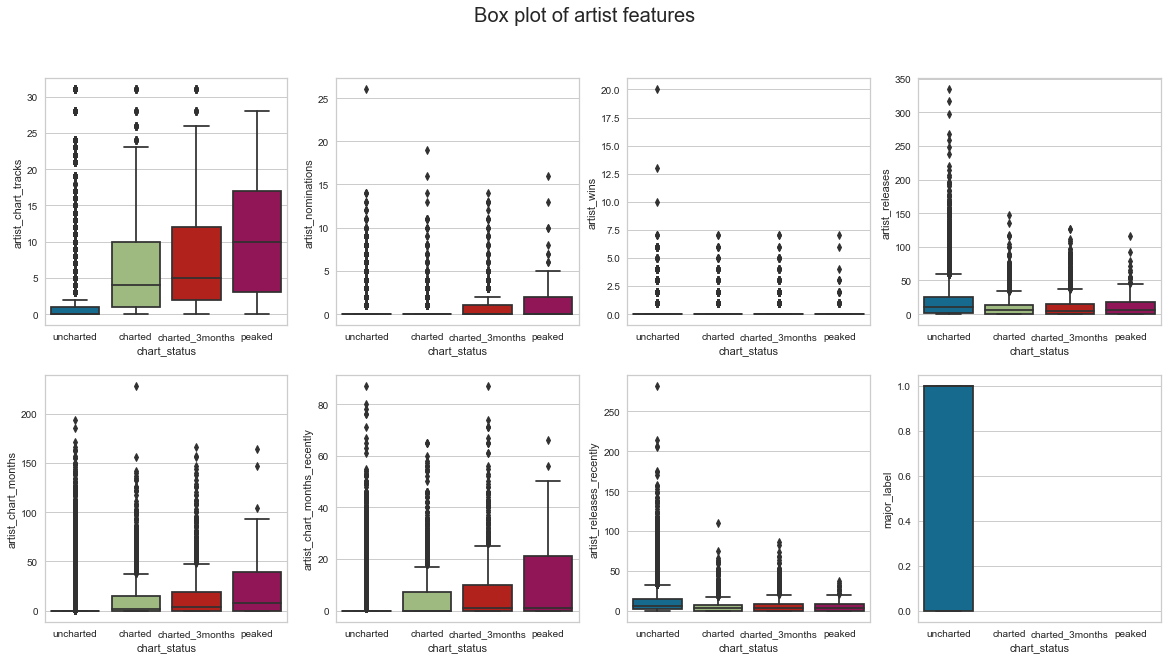

In [9]:
ncols = 4
nrows = int(len(artist_features) / 4)

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 5 * nrows))
fig.suptitle("Box plot of artist features", fontsize=20)

for row in range(nrows):
    for col in range(ncols):
        idx = (row * ncols) + (col + 1) - 1
        if idx > len(artist_features):
            break
        sns.boxplot(data=tracks_df, x="chart_status", y=artist_features[idx], ax=axs[row, col],
                    order=["uncharted", "charted", "charted_3months", "peaked"])

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

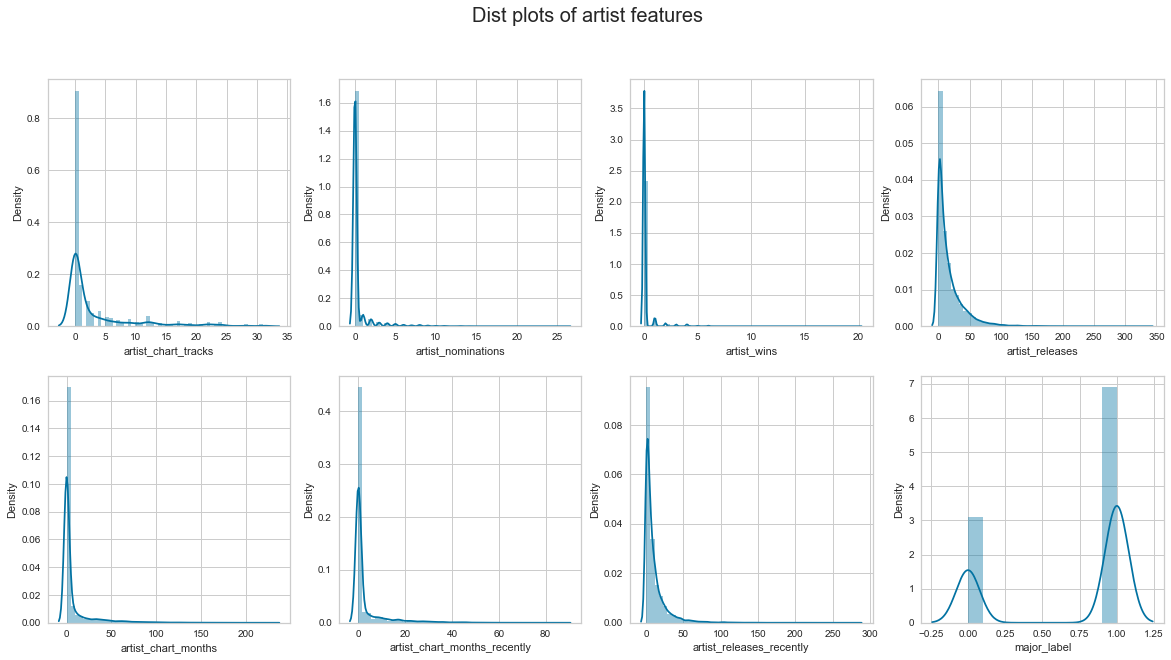

In [10]:
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 5 * nrows))
fig.suptitle("Dist plots of artist features", fontsize=20)

ncols = 4
nrows = int(len(artist_features) / 4)

for row in range(nrows):
    for col in range(ncols):
        idx = (row * ncols) + (col + 1) - 1
        if idx > len(artist_features):
            break
        sns.distplot(tracks_df[artist_features[idx]], ax=axs[row, col])

## Revenue Analysis

According to Chart2000: "rough guess is that each unit of Indicative Revenue score represents something like $5,000 of TOTAL revenue generated across the **whole music delivery chain** (in year 2000 dollars). It is reasonable to expect that artists will get at the very most about 10% of this revenue."

In [11]:
df_ = tracks_df.copy()
df_["revenue_est_total"] = df_["track_chart_indicativerevenue"] * 5000.0 / 1000.0
df_["revenue_est_artist"] = df_["revenue_est_total"] * .10
df_["revenue_est_total"].describe()

count     14996.000000
mean       5548.868022
std       15713.359575
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      270898.290000
Name: revenue_est_total, dtype: float64

In [12]:
df_[["artists", "name", "revenue_est_total"]].sort_values(["revenue_est_total"], ascending=False)

,artists,name,revenue_est_total
14520,The Weeknd,Blinding Lights,270898.290
969,Ed Sheeran,Shape of You,164355.470
4177,Lewis Capaldi,Someone You Loved,164177.095
13870,Post Malone,Circles,161989.040
11164,Billie Eilish,bad guy,152528.525
...,...,...,...
5627,The Asteroids Galaxy Tour,Crazy,0.000
5630,Dwayne Johnson,You're Welcome,0.000
5632,Yo Gotti,Down In the DM,0.000
5633,Gleb,Go Go Go,0.000


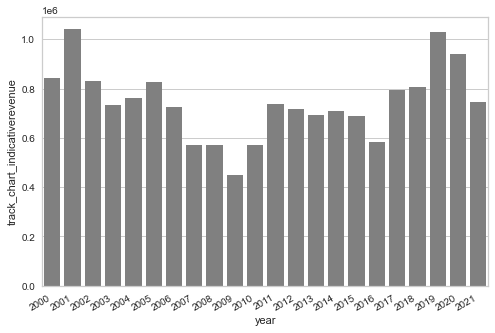

In [13]:
year_revenue = (
    tracks_df
        .groupby("year")
        .aggregate({"track_chart_indicativerevenue": "sum"})
        .reset_index()
)
year_revenue = year_revenue[year_revenue["year"] != 2022]
plot = sns.barplot(x="year", y="track_chart_indicativerevenue", data=year_revenue, color="gray")
plot.get_figure().autofmt_xdate()

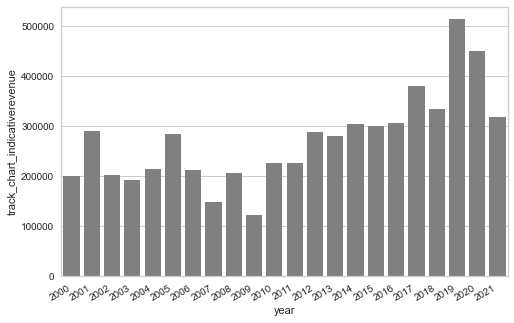

In [14]:
year_revenue = (
    tracks_df
        [tracks_df["track_chart_months"] > 6]
        .groupby("year")
        .aggregate({"track_chart_indicativerevenue": "sum"})
        .reset_index()
)
year_revenue = year_revenue[year_revenue["year"] != 2022]
plot = sns.barplot(x="year", y="track_chart_indicativerevenue", data=year_revenue, color="gray")
plot.get_figure().autofmt_xdate()

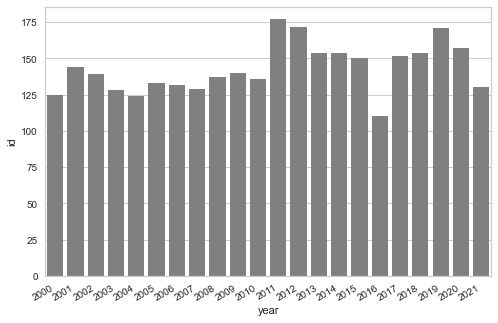

In [15]:
year_count = (
    tracks_df
        [tracks_df["track_chart_months"] > 0]
        .groupby("year")
        .aggregate({"id": "count"})
        .reset_index()
)
year_count = year_count[year_count["year"] != 2022]
plot = sns.barplot(x="year", y="id", data=year_count, color="gray")
plot.get_figure().autofmt_xdate()

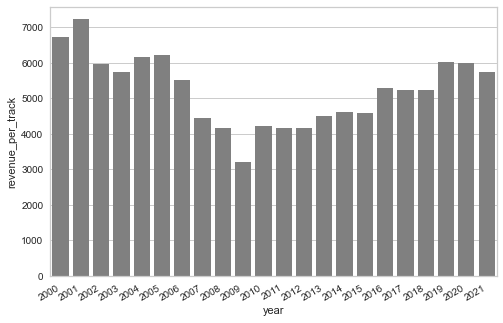

In [16]:
# normalized revenue
year_revenue = (
    tracks_df
        [tracks_df["track_chart_months"] > 0]
        .groupby("year")
        .aggregate({
            "track_chart_indicativerevenue": "sum",
            "id": "count",
        })
        .reset_index()
)
year_revenue = year_revenue[year_revenue["year"] != 2022]
year_revenue["revenue_per_track"] = year_revenue["track_chart_indicativerevenue"] / year_revenue["id"]
plot = sns.barplot(x="year", y="revenue_per_track", data=year_revenue, color="gray")
plot.get_figure().autofmt_xdate()

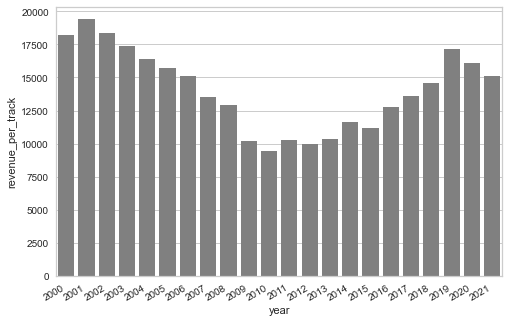

In [17]:
# normalized revenue
year_revenue = (
    tracks_df
    [tracks_df["track_chart_months"] > 6]
        .groupby("year")
        .aggregate({
        "track_chart_indicativerevenue": "sum",
        "id": "count",
    })
        .reset_index()
)
year_revenue = year_revenue[year_revenue["year"] != 2022]
year_revenue["revenue_per_track"] = year_revenue["track_chart_indicativerevenue"] / year_revenue["id"]
plot = sns.barplot(x="year", y="revenue_per_track", data=year_revenue, color="gray")
plot.get_figure().autofmt_xdate()

## Charts Analysis

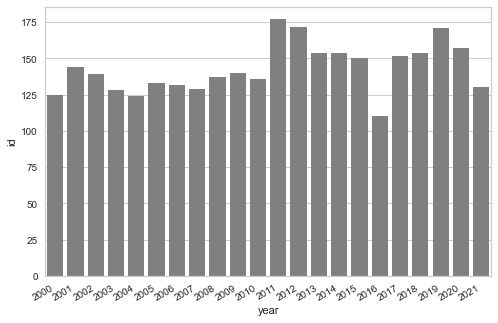

In [18]:
# number of charting songs per year
year_charts = (
    tracks_df
    [tracks_df["track_chart_months"] > 0]
        .groupby("year")
        .aggregate({
            "track_chart_months": "sum",
            "id": "count",
        })
        .reset_index()
)
year_charts = year_charts[year_charts["year"] != 2022]
plot = sns.barplot(x="year", y="id", data=year_charts, color="gray")
plot.get_figure().autofmt_xdate()

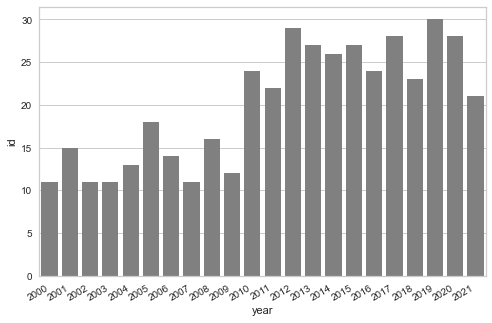

In [19]:
# number of 6+ months charting songs per year
year_charts = (
    tracks_df
    [tracks_df["track_chart_months"] > 6]
        .groupby("year")
        .aggregate({
            "track_chart_months": "sum",
            "id": "count",
    })
    .reset_index()
)
year_charts = year_charts[year_charts["year"] != 2022]
plot = sns.barplot(x="year", y="id", data=year_charts, color="gray")
plot.get_figure().autofmt_xdate()

In [20]:
(
    tracks_df
        [tracks_df["track_chart_months"] > 6]
        .sort_values(["year", "track_chart_months"], ascending=(True, False))
        [["year", "name", "artists", "track_chart_months"]]
)

,year,name,artists,track_chart_months
2500,2000,Hanging By A Moment,Lifehouse,11.0
8362,2000,Kryptonite,3 Doors Down,10.0
8653,2000,In the End,Linkin Park,9.0
9465,2000,I Hope You Dance,Lee Ann Womack,9.0
6228,2000,Bent,Matchbox Twenty,8.0
...,...,...,...,...
959,2022,Castle On the Hill,Ed Sheeran,8.0
7016,2022,I Knew You Were Trouble (Taylor's Version),Taylor Swift,8.0
7936,2022,Telephone - w/o Beyonce,Lady Gaga,8.0
6522,2022,Break My Heart,Dua Lipa,7.0


## Audio feature analysis

/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_10525/3262626429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df["track_chart_months"] = model_df["track_chart_months"].apply(lambda v: 5 if v > 5 else v)
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/yellowbrick/features/radviz.py:199: RuntimeWarning: invalid value encountered in true_divide
  xy = (s * row_).sum(axis=0) / row.sum()


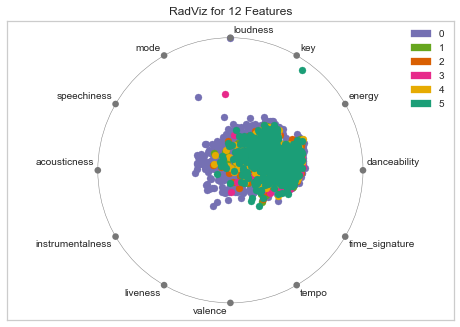

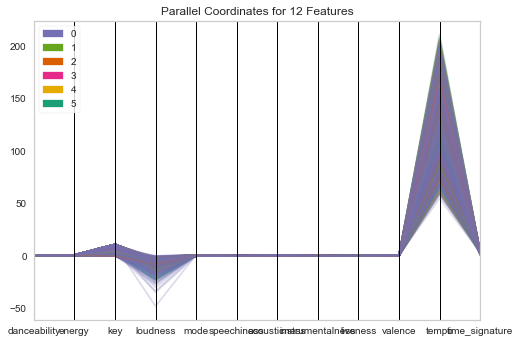

<AxesSubplot:title={'center':'Parallel Coordinates for 12 Features'}>

In [26]:
model_df = tracks_df[audio_features + ["track_chart_months"]]
model_df["track_chart_months"] = model_df["track_chart_months"].apply(lambda v: 5 if v > 5 else v)
model_df = model_df.dropna().reset_index(drop=True)
X = model_df.drop(columns=["track_chart_months"]).reset_index(drop=True)
y = model_df["track_chart_months"]

# classes = [0, 1]
classes = [0, 1, 2, 3, 4, 5]
visualizer = RadViz(classes=classes)
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

visualizer = ParallelCoordinates(
    classes=classes, features=X.columns, sample=0.25, shuffle=True, random_state=42
)
visualizer.fit_transform(X, y)
visualizer.show()

## Artist feature analysis

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/yellowbrick/features/radviz.py:199: RuntimeWarning: invalid value encountered in true_divide
  xy = (s * row_).sum(axis=0) / row.sum()


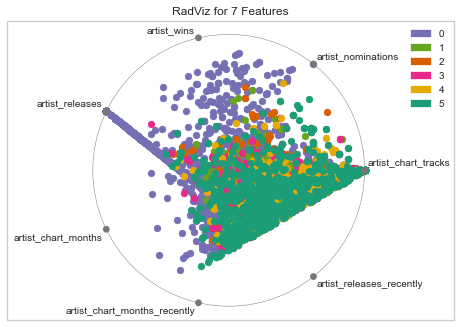

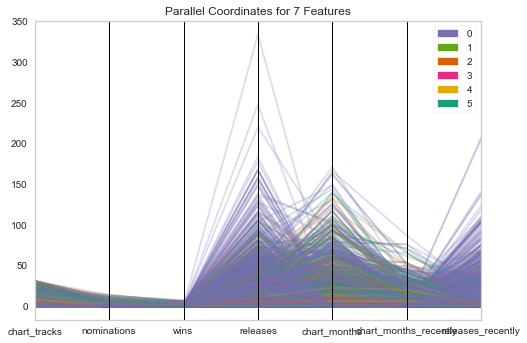

<AxesSubplot:title={'center':'Parallel Coordinates for 7 Features'}>

In [34]:
model_df = tracks_df[artist_features + ["track_chart_months"]].drop(columns="major_label")
model_df["track_chart_months"] = model_df["track_chart_months"].apply(lambda v: 5 if v > 5 else v)
model_df = model_df.dropna().reset_index(drop=True)
X = model_df.drop(columns=["track_chart_months"]).reset_index(drop=True)
y = model_df["track_chart_months"]

# classes = [0, 1]
classes = [0, 1, 2, 3, 4, 5]
visualizer = RadViz(classes=classes)
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

feature_names_clean = [col.replace("artist_", "") for col in X.columns]
visualizer = ParallelCoordinates(
    classes=classes, features=feature_names_clean, sample=0.25, shuffle=True, random_state=42
)
visualizer.fit_transform(X, y)
visualizer.show()

## Feature importance

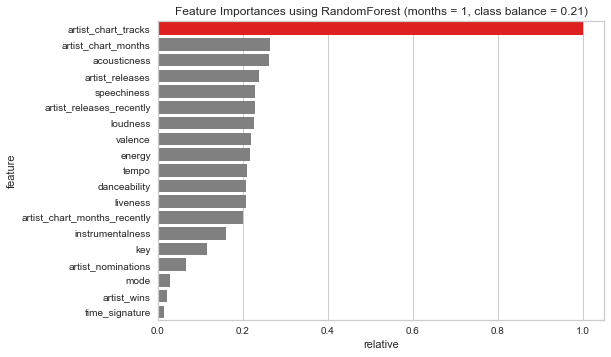

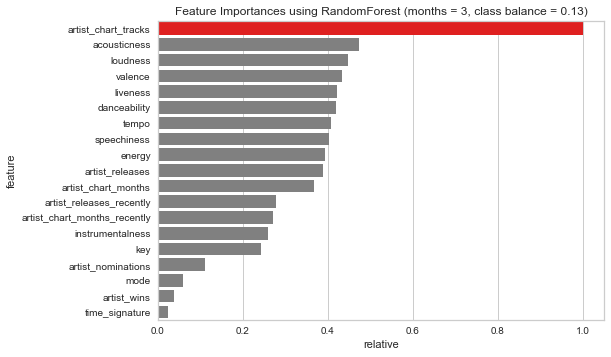

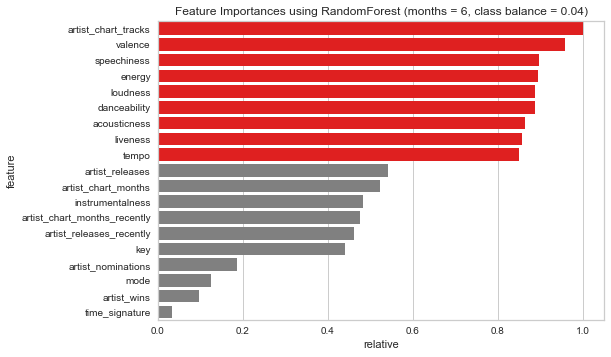

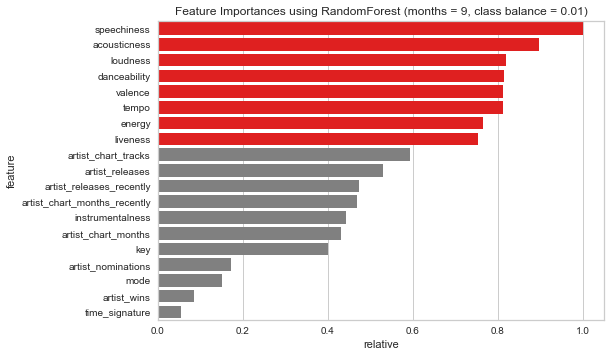

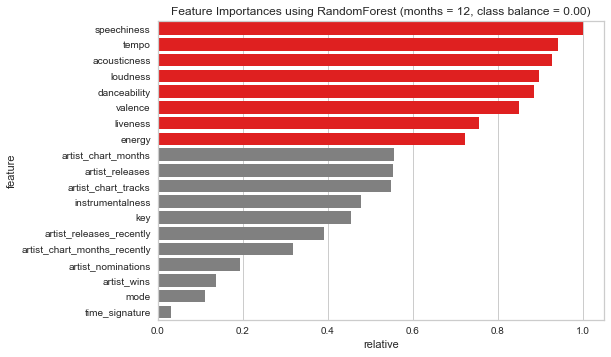

In [35]:
def plot_feature_importance(tracks_df, months, features=audio_features + artist_features):
    X_train, X_test, y_train, y_test = create_test_train_datasets(tracks_df, x_vars=features, months=months)
    class_balance = (y_test == 1).sum() / len(y_test)

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    feature_importances = pd.DataFrame(
        list(zip(X_train.columns, rf.feature_importances_)),
        columns=["feature", "importance"]
    ).sort_values("importance", ascending=False)
    feature_importances["relative"] = feature_importances["importance"] / np.max(feature_importances["importance"])

    plt.figure()
    g = sns.barplot(x="relative", y="feature", data=feature_importances,
                    palette=np.where(feature_importances["relative"] >= 0.6, "red", "gray"))
    g.set_title(f"Feature Importances using RandomForest (months = {months}, class balance = {class_balance:.2f})")


plot_feature_importance(tracks_df, 1)
plot_feature_importance(tracks_df, 3)
plot_feature_importance(tracks_df, 6)
plot_feature_importance(tracks_df, 9)
plot_feature_importance(tracks_df, 12)

## Feature selection

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


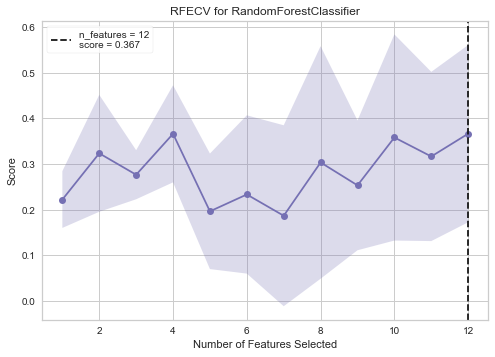

['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']


In [73]:
df_ = tracks_df.sample(frac=0.05)

X = df_[audio_features]
y = (df_["track_chart_months"] >= 1).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_audio_features_1_month = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_audio_features_1_month)

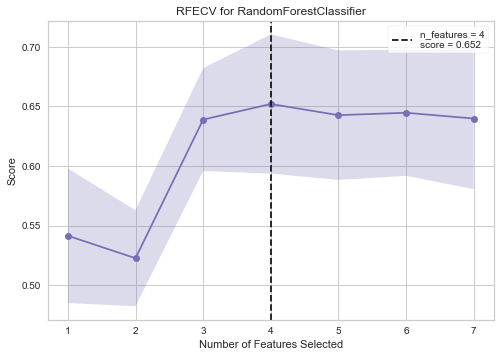

['artist_chart_tracks', 'artist_releases', 'artist_chart_months', 'artist_releases_recently']


In [74]:
df_ = tracks_df.sample(frac=0.05)

X = df_[artist_features].drop(columns="major_label")
y = (df_["track_chart_months"] >= 1).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_artist_features_1_month = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_artist_features_1_month)

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

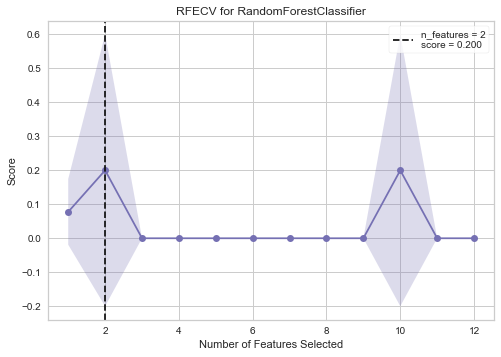

['loudness', 'acousticness']


In [75]:
df_ = tracks_df.sample(frac=0.05)

X = df_[audio_features]
y = (df_["track_chart_months"] >= 6).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_audio_features_6_months = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_audio_features_6_months)

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

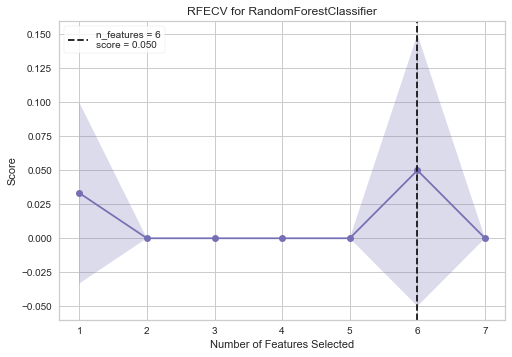

['artist_chart_tracks', 'artist_nominations', 'artist_releases', 'artist_chart_months', 'artist_chart_months_recently', 'artist_releases_recently']


In [76]:
df_ = tracks_df.sample(frac=0.05)

X = df_[artist_features].drop(columns="major_label")
y = (df_["track_chart_months"] >= 6).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_artist_features_6_months = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_artist_features_6_months)

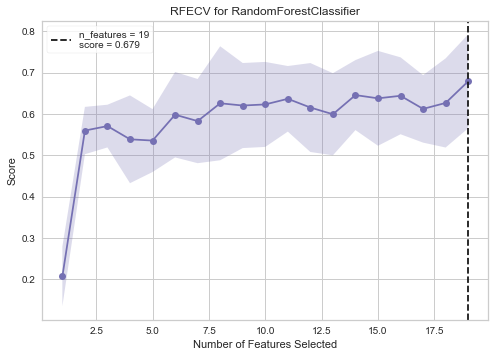

['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'artist_chart_tracks', 'artist_nominations', 'artist_wins', 'artist_releases', 'artist_chart_months', 'artist_chart_months_recently', 'artist_releases_recently']


In [77]:
df_ = tracks_df.sample(frac=0.05)

X = df_[audio_features + artist_features].drop(columns="major_label")
y = (df_["track_chart_months"] >= 1).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_features_1_month = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_features_1_month)

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

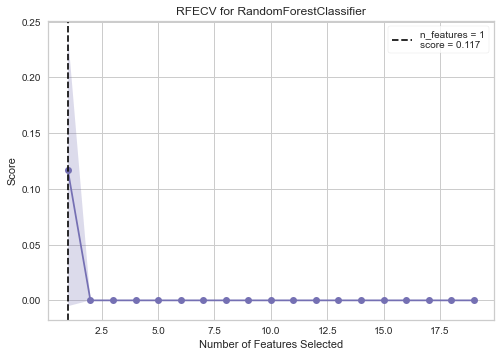

In [65]:
df_ = tracks_df.sample(frac=0.05)

X = df_[audio_features + artist_features].drop(columns="major_label")
y = (df_["track_chart_months"] >= 6).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_features_6_months = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_features_6_months)

## Null model

In [56]:
X_train, X_test, y_train, y_test = create_test_train_datasets(tracks_df, x_vars=[], months=1)
precision = precision_score(y_test,  [1] * len(y_test))
f1 = f1_score(y_test,  [1] * len(y_test))
print(f"null score (charted = 1 month): precision={1 - precision:.5f}, f1={1 - f1:.5f}, class size={(y_test == 1).sum()} ({(y_test == 1).sum() / len(y_test) * 100:.2f}%)")

X_train, X_test, y_train, y_test = create_test_train_datasets(tracks_df, x_vars=[], months=6)
precision = precision_score(y_test,  [1] * len(y_test))
f1 = f1_score(y_test,  [1] * len(y_test))
print(f"null score (charted = 6 month): precision={1 - precision:.5f}, f1={1 - f1:.5f}, class size={(y_test == 1).sum()} ({(y_test == 1).sum() / len(y_test) * 100:.2f}%)")

null score (charted = 1 month): precision=0.78696, f1=0.64876, class size=1278 (21.30%)
null score (charted = 6 month): precision=0.95533, f1=0.91447, class size=268 (4.47%)


## Artist features classification model report (1 month)

train score: 0.80282, accuracy=0.80282, precision=0.53246, f1=0.56942
test score: 0.80547, accuracy=0.80547, precision=0.53841, f1=0.57143


/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


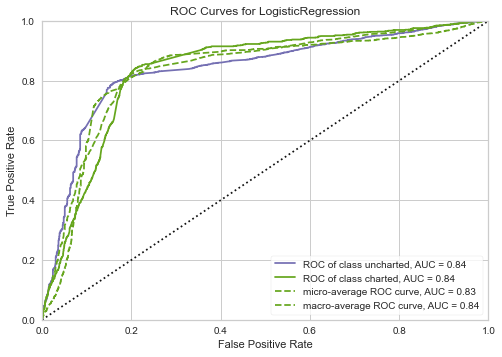

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


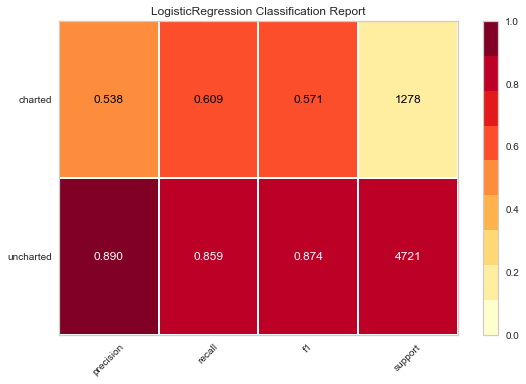

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


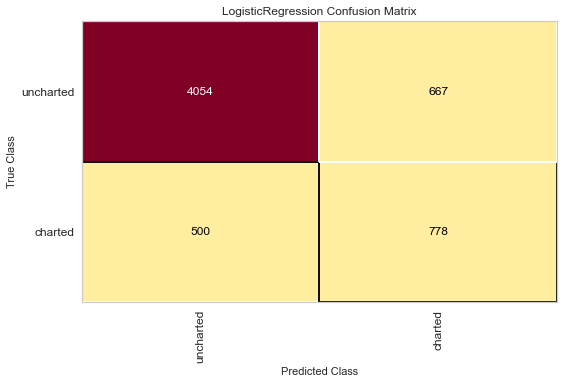

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


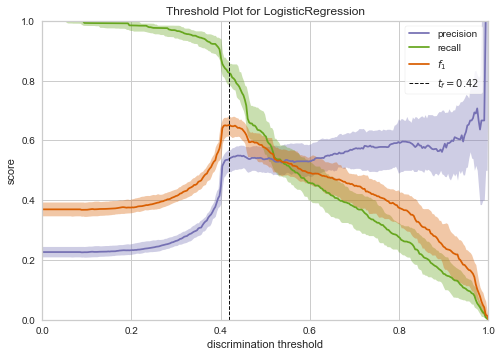

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


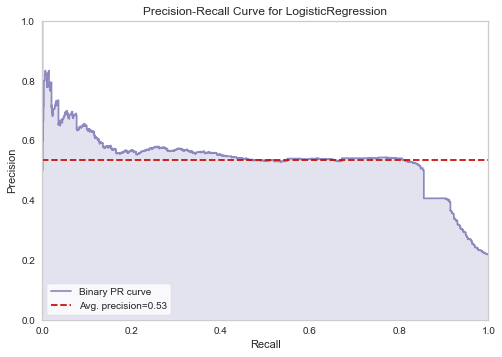

   artist_chart_tracks  artist_nominations  artist_wins  artist_releases  \
0             1.241614            1.018206     0.706513         1.003889   

   artist_chart_months  artist_chart_months_recently  artist_releases_recently  
0              0.97379                      1.024445                   0.95477  


In [68]:
def create_classification_report(df, features, model, months=1):
    X_train, X_test, y_train, y_test = create_test_train_datasets(df, features, months=months)
    model = LogisticRegression(max_iter=1000, class_weight="balanced")
    model.fit(X_train, y_train)

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    train_precision = precision_score(y_train, model.predict(X_train))
    train_f1 = f1_score(y_train, model.predict(X_train))

    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    test_precision = precision_score(y_test, model.predict(X_test))
    test_f1 = f1_score(y_test, model.predict(X_test))

    print(f"train score: {train_score:.5f}, accuracy={train_accuracy:.5f}, precision={train_precision:.5f}, f1={train_f1:.5f}")
    print(f"test score: {test_score:.5f}, accuracy={test_accuracy:.5f}, precision={test_precision:.5f}, f1={test_f1:.5f}")

    # model = LogisticRegression(multi_class="auto", solver="liblinear")
    visualizer = ROCAUC(model, classes=["uncharted", "charted"])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

    visualizer = ClassificationReport(model, classes=["uncharted", "charted"], support=True)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

    visualizer = ConfusionMatrix(model, classes=["uncharted", "charted"], support=True)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

    visualizer = DiscriminationThreshold(model, exclude=["queue_rate"])
    visualizer.fit(X_test, y_test)
    visualizer.show()

    viz = PrecisionRecallCurve(model)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()

    print(pd.DataFrame(np.exp(model.coef_), columns=X_train.columns).head())


lr_artist = LogisticRegression(max_iter=1000, class_weight="balanced")
create_classification_report(tracks_df, artist_features, lr_artist, months=1)

## Artist features classification model report (6 month)

train score: 0.79571, accuracy=0.79571, precision=0.11652, f1=0.19173
test score: 0.80463, accuracy=0.80463, precision=0.12144, f1=0.19836


/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


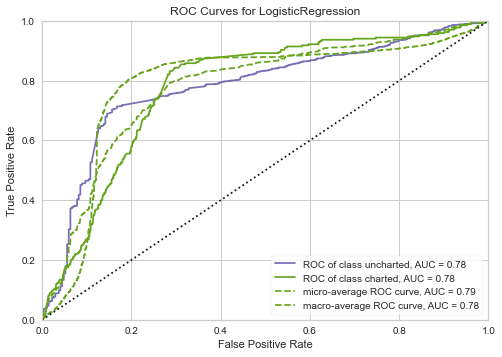

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


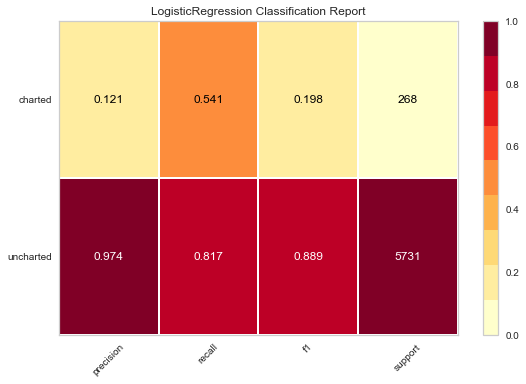

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


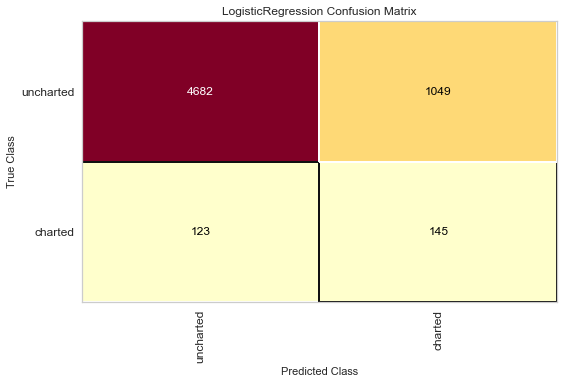

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


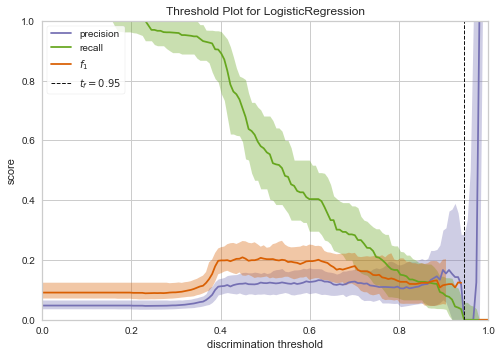

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


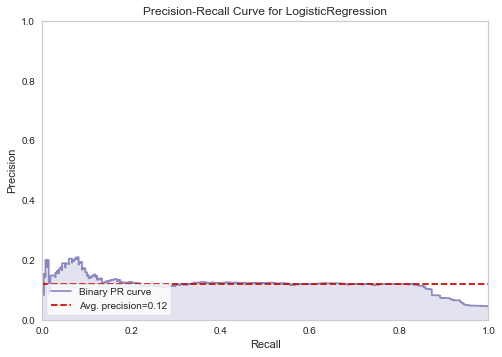

   artist_chart_tracks  artist_nominations  artist_wins  artist_releases  \
0             1.149529            1.012917     0.902575         1.006443   

   artist_chart_months  artist_chart_months_recently  artist_releases_recently  
0             0.985188                      1.022552                  0.961635  


In [78]:
lr_artist = LogisticRegression(max_iter=1000, class_weight="balanced")
create_classification_report(tracks_df, artist_features, lr_artist, months=6)


## Audio features classification model report (1 month)

train score: 0.55530, accuracy=0.55530, precision=0.27701, f1=0.39296
test score: 0.57269, accuracy=0.57269, precision=0.28830, f1=0.40575


/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


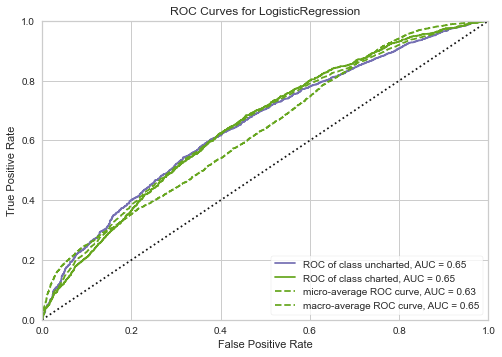

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


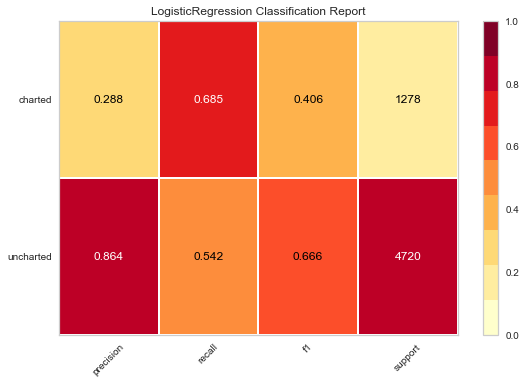

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


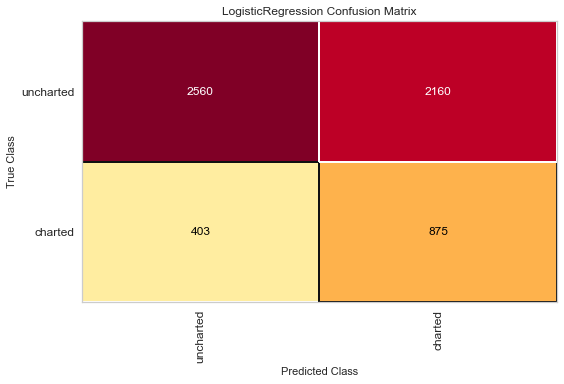

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


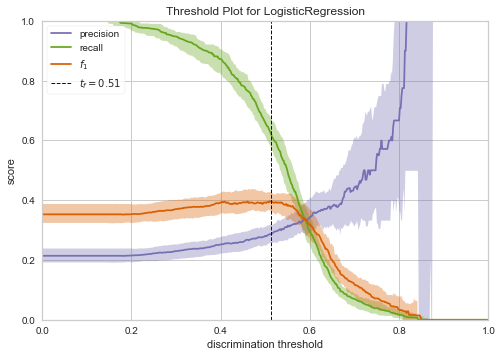

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


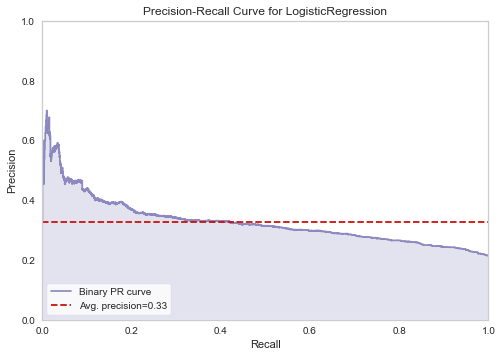

   danceability    energy       key  loudness      mode  speechiness  \
0      0.557523  0.464016  1.015823  1.005053  1.184356     0.578671   

   acousticness  instrumentalness  liveness   valence     tempo  \
0      0.133867          2.353939   0.65331  1.967384  0.996291   

   time_signature  
0        1.186853  


In [69]:
lr_audio_1 = LogisticRegression(max_iter=1000, class_weight="balanced")
create_classification_report(tracks_df, audio_features, lr_artist, months=1)

## Audio features classification model report (6 month)

train score: 0.53618, accuracy=0.53618, precision=0.05896, f1=0.10776
test score: 0.52951, accuracy=0.52951, precision=0.05752, f1=0.10526


/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


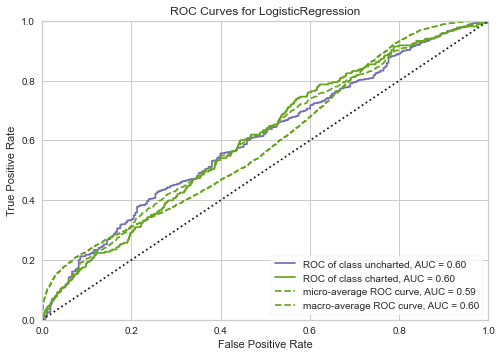

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


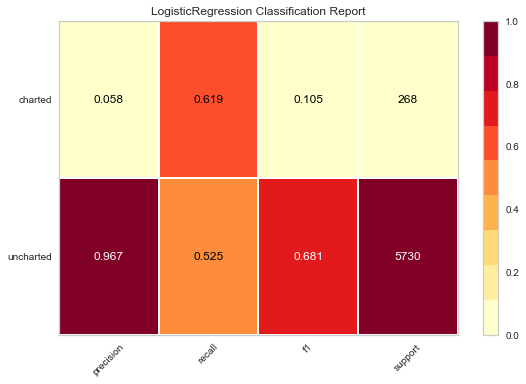

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


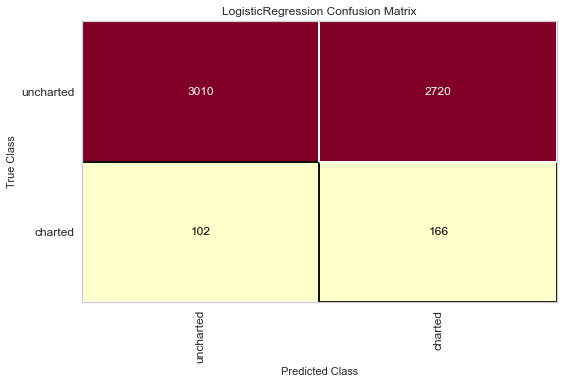

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


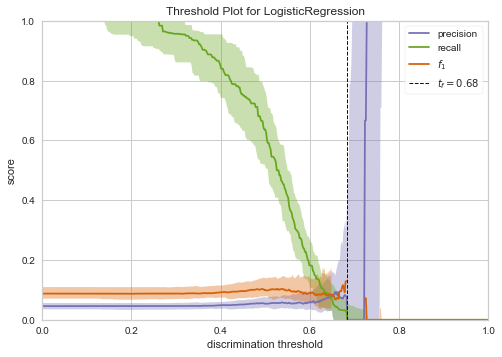

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


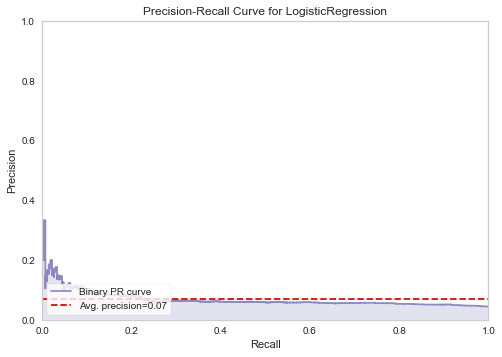

   danceability   energy       key  loudness      mode  speechiness  \
0      2.436806  0.58098  0.985845  1.026606  1.040619      0.10127   

   acousticness  instrumentalness  liveness   valence     tempo  \
0      0.265794          1.889434  0.387297  1.726649  0.999317   

   time_signature  
0        1.355551  


In [70]:
lr_audio_6 = LogisticRegression(max_iter=1000, class_weight="balanced")
create_classification_report(tracks_df, audio_features, lr_artist, months=6)

In [2]:
tracks_df

NameError: name 'tracks_df' is not defined